[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rupaltotale/Movie-Genre-Predictor/blob/master/Machin%20Learning.ipynb)
# Machine Learning

In this section, we build a machine learning model to predict genre(s) for a movie. Since our prediction can span multiple values, we will have to use a multi-label classification model. 

## Setup

### Make needed imports

In [0]:
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import *
from google.colab import files
from io import BytesIO
import numpy as np
from sklearn.linear_model import *
from sklearn.metrics import *
from google.colab import drive

In [2]:
# Import multiclass library from scikit
!pip install scikit-multilearn

     |████████████████████████████████| 92kB 2.5MB/s 


### Setup Drive and dataset

In [94]:
drive.mount('drive')
data_dir = "drive/My Drive/301 Project/Data/"
df_movies = pd.read_csv(data_dir + "cleaned_dataframe.csv").drop(
    columns=["Unnamed: 0"],
    axis=1
)

# We randomly sample 10 observations that are not trained on to use for predictions
df_movies_test = df_movies.sample(10)
df_movies_test = df_movies_test.reset_index().drop(columns=["index"])

df_movies = df_movies.set_index("id").drop(df_movies_test.id).reset_index()
df_movies.head()

,id,Animation,Horror,Mystery,Fantasy,Romance,TV Movie,Family,Documentary,Western,Science Fiction,Foreign,Crime,Adventure,Thriller,Comedy,War,Drama,History,Action,Music,original_title,budget,overview,popularity,production_companies,revenue,runtime,tagline,vote_average,vote_count,collection,Composer,Director,Screenplay,cast,keywords,rating_average,userId_who_like
0,862,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,Toy Story,30000000,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar_Animation_Studios,373554033.0,81.0,NaN,7.7,5415.0,Toy_Story_Collection,NaN,John_Lasseter,Alec_Sokolow,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,jealousy toy boy friendship friends rivalry bo...,3.598930,2103 6177 6525 8659 9328 9682 11214 13839 1523...
1,8844,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,Jumanji,65000000,When siblings Judy and Peter discover an encha...,17.015539,TriStar_Pictures Teitler_Film Interscope_Commu...,262797249.0,104.0,Roll the dice and unleash the excitement!,6.9,2413.0,NaN,James_Horner,Joe_Johnston,Jim_Strain,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,board_game disappearance based_on_children's_b...,3.760163,7016 7144 8659 9547 13399 17808 24266 25209 26...
2,949,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,Heat,60000000,"Obsessive master thief, Neil McCauley leads a ...",17.924927,Regency_Enterprises Forward_Pass Warner_Bros.,187436818.0,170.0,A Los Angeles Crime Saga,7.7,1886.0,NaN,Elliot_Goldenthal,Michael_Mann,Michael_Mann,Al_Pacino Robert_De_Niro Val_Kilmer Jon_Voight...,robbery detective bank obsession chase shootin...,3.905544,174 346 362 384 523 557 609 624 773 825 959 11...
3,710,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,GoldenEye,58000000,James Bond must unmask the mysterious head of ...,14.686036,United_Artists Eon_Productions,352194034.0,130.0,No limits. No fears. No substitutes.,6.6,1194.0,James_Bond_Collection,Eric_Serra,Martin_Campbell,Bruce_Feirstein,Pierce_Brosnan Sean_Bean Izabella_Scorupco Fam...,cuba falsely_accused secret_identity computer_...,2.740334,2073 2709 2967 4241 4389 4916 5463 5811 5980 8...
4,1408,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,Cutthroat Island,98000000,"Morgan Adams and her slave, William Shaw, are ...",7.284477,Le_Studio_Canal+ Laurence_Mark_Productions Met...,10017322.0,119.0,The Course Has Been Set. There Is No Turning B...,5.7,137.0,NaN,NaN,Renny_Harlin,Robert_King,Geena_Davis Matthew_Modine Frank_Langella Maur...,exotic_island treasure map ship scalp pirate,3.710181,15 65 68 98 115 151 153 193 231 288 326 340 34...


### Determine if tests should be run
This is used to determine if certain tests that take a while should be run or not. 

Note: Type **yes** or **no** after running this cell. 

In [105]:
should_run_tests = input("Do you want to run tests [y/n]?\n")
if should_run_tests == "y" or should_run_tests == "yes":
  should_run_tests = True
else:
  should_run_tests = False

Do you want to run tests [y/n]?
y


### Clean DataFrame, extract y_train (genre), define feature types



**Rationale behind cleaning collections:**
Any movie not part of a colleciton has its collection set as its title. This way we can still use collection as a feature to test, since in our testing we dropna, so we would lose many movies since most movies are not part of a collection. The code below fixes that problem.

In [0]:
# Get all genres (which is our y_train)
genres = list(df_movies.columns[:20])

# Define the types of movie features
testing_types = {
  'Composer' : "ohe",
  'Director' : "ohe",
  'Screenplay' : "ohe",
  'budget' : "scale",
  'cast' : "tfidf",
  'collection' : "ohe",
  'keywords' : "tfidf",
  'original_title' : "tfidf",
  'overview' : "tfidf",
  'popularity' : "scale",
  'production_companies' : "tfidf",
  'rating_average' : "scale",
  'revenue' : "scale",
  'runtime' : "scale",
  'userId_who_like' : "tfidf",
  'vote_average' : "scale",
  'vote_count' : "scale",
  'tagline' : "tfidf",
  'mod_overview' : "tfidf"
}

# Clean collections
df_movies["collection"] = df_movies["collection"].fillna(
    df_movies["original_title"]
)

# From our visual exploration conclusion
# We don't consider "userId_who_like" because it takes too long to run and 
# may not be worth the effort. 
expected_good_features = [
    "budget", "popularity", "revenue", 
    "vote_count", "collection",
    "cast", "keywords"
]

## Defining helper functions to build our ML model

### Helper methods for scoring our models

In [0]:
def my_score_with_average_and_scoring(scoring, average):
  """
    Returns the function (f1_score, precision_score, etc.)
    with the average set as well. This way, we can pass a scoring 
    function with an average that's not automatically
    set to binary
  """
  def my_score_with_average_set(y_true, y_pred, **kwargs):
    return scoring(y_true, y_pred, average=average, **kwargs)
  return make_scorer(my_score_with_average_set)

### Helper functions to build our models

##### Helper function to build a model

In [0]:
def give_certain_models(label_model, classifier_model,
                        label_model_kwargs={}, classifier_model_kwargs={},
                        use_dense=False):
  """
    label_model: Usually OneVsRestClassifier
    classifier_model: what's passed into OneVsRestClassifier

    - You can optionally pass kwargs into each too

    Returns a model that can be passed into assemble.
  """
  def specific_model_to_use(cts, X_train, y_train):
    """
      Creates that actual model based on variables passed in outer function
      -  Unpacks ColumnTransformers and unpacks optional kwargs for the pipeline
    """
    if use_dense:
      model = make_pipeline(
          *cts, # Unpack all the ColumnTransformers
          FunctionTransformer(lambda x: x.todense(), accept_sparse=True),
          label_model(
              classifier_model(**classifier_model_kwargs), **label_model_kwargs
          )
      )
    else:
      model = make_pipeline(
          *cts,
          label_model(
              classifier_model(**classifier_model_kwargs), **label_model_kwargs
          )
      )
    model.fit(X=X_train, y=y_train)
    return model
  return specific_model_to_use

##### Helper functions to build a ColumnTransformer

In [0]:
def create_default_tfidf_transformers(column_list):
  """
    Returns a ColumnTransformer containing all tfidf columns passed
    into this
  """
  tuple_list = [(TfidfVectorizer(), col) for col in column_list]
  return make_column_transformer(
      *tuple_list,
      remainder="passthrough"
  )

def combine_column_transformers(cts):
  """
    Input: list of ColumnTransformers
    Returns: a ColumnTransformer where all CTs
      passed in are combined into one single CT 
  """
  new_l = []
  for ct in cts:
    for transform in ct.transformers:
      # transform[1] is the actual transformation (i.e. OneHotEncoder)
      # transform[2] are the columns involved for that CT
      new_l.append((transform[1], transform[2]))
  if len(new_l) == 0:
    return []
  return make_column_transformer(
      *new_l, # Unpack all CTs, as if they were typed separately
      remainder="passthrough"
  )


def get_transformers_and_columns_for_features(features, testing_types):
  """
    Input: columns (features) and map of feature names to their CT types
    Returns: dictionary of columns for each transformation type, the CTS
      themselves, and the combined CT
  """
  
  # Get appropriate transformer columns based on features passed in
  tfidf_cols = [col for col in features if testing_types[col] == "tfidf"]
  ohe_cols = [col for col in features if testing_types[col] == "ohe"]
  scale_cols = [col for col in features if testing_types[col] == "scale"]

  # Initialize default values for each CT
  tfidf_col_transformer, ohe_col_transformer, scale_col_transformer = [], [], []

  if len(tfidf_cols) > 0:
    # Get CT for tfidf
    tfidf_col_transformer = [create_default_tfidf_transformers(tfidf_cols)]
  if len(ohe_cols) > 0:
    # Get CT for OHE
    ohe_col_transformer = [make_column_transformer(
        (OneHotEncoder(handle_unknown="ignore"), ohe_cols),
        remainder="passthrough"
    )]
  if len(scale_cols) > 0:
    # Get CT for scaling
    scale_col_transformer = [make_column_transformer(
        (StandardScaler(), scale_cols),
        remainder="passthrough"
    )]
    
  return {
      "tfidf_cols" : tfidf_cols,
      "ohe_cols" : ohe_cols,
      "scale_cols" : scale_cols,
      "tfidf_col_transformer" : tfidf_col_transformer,
      "ohe_col_transformer" : ohe_col_transformer,
      "scale_col_transformer" : scale_col_transformer,
      "combined_transformers" : [combine_column_transformers(
            tfidf_col_transformer + 
            ohe_col_transformer + 
            scale_col_transformer
        )]
  }

#### Helper function for graphing visuals

In [0]:
def graph_values(x, y, graph_type, x_label="", y_label="", graph_name=""):
  ax = pd.Series(x, index=y).sort_values().plot(
      kind=graph_type, 
      title=graph_name
  )
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)

#### Assemblers

##### Helper function that assembles a model

Gathers needed data from columns for training, sets up the models, and optionally returns the DataFrame for the predictions or reports a cross validation score of the estimator

In [0]:
def assemble(
    ohe=[], 
    tfidf=[], 
    scale=[], 
    show_error = False, # Do cross validation
    model=None, # Model to use for fitting and predicting
    cts=[], # All CTs
    scoring=my_score_with_average_and_scoring(f1_score, "micro"),
    y_train_cols=genres,
    silent=False, # Whether to print stuff or not, other than final score 
    full_silent=False, # Whether to print stuff or not for everything
):
  """
    Main ML.
    Input: 
      - ohe, tfidf, and scale are all columns
      - cts will relate to columns above
      - scoring by default is f1
    Returns:
      - cross validation score OR estimator/model for predictions
    What it does:
      - Trains the model
      - Does cross validation on the model if wanted
  """
  if not silent and not full_silent:
    print("Using model:", model)
  features = ohe +  tfidf + scale
  if not silent and not full_silent:
    print("Using features:", features)

  # Training data
  df_train = df_movies[features + y_train_cols].dropna()
  X_train = df_train[features]
  y_train = df_train[y_train_cols]

  # Based on model passed in, train the model and build its pipeline
  if len(cts) == 0:
    ct = make_column_transformer(
        (StandardScaler(), scale),
        (OneHotEncoder(handle_unknown="ignore"), ohe),
        remainder="drop",
    )
    estimator = model([ct], X_train, y_train)
  else:
    estimator = model(cts, X_train, y_train)

  if not silent and not full_silent:
    print("Model fit...")

  if show_error:
    # Does cross validation
    if not silent and not full_silent:
      print("Starting cross val")
    score = (cross_validate(
          estimator,
          X=X_train,
          y=y_train,
          scoring=scoring,
          cv=5
      )['test_score']).mean()
    if not silent and not full_silent:
      print("Score for features {}: {}".format(features, score))
    else:
      if not full_silent:
        print(score)
    return score
  
  return estimator

##### Helper function to score the estimator returned by `assemble()` defined above

In [0]:
def get_assemble_score(
    features, 
    testing_types,
    model, 
    scoring=my_score_with_average_and_scoring(
        f1_score, "micro"
    ),
    be_silent=True,
):
  """
    Does most of the assembling for you. Used to get cross validation score
    by default, bu can still get estimator if wanted
  """
  # Get appropriate dictionary of CTs and related columns
  t_c_dic = get_transformers_and_columns_for_features(features, testing_types)
  
  # Run assemble and either get score or estimator/predictor
  return assemble(
    ohe=t_c_dic["ohe_cols"],
    scale=t_c_dic["scale_cols"],
    tfidf=t_c_dic["tfidf_cols"],
    show_error=True,
    scoring=scoring,
    model=model,
    cts=(
        t_c_dic["combined_transformers"]
    ),
    full_silent=be_silent
  )

##### Helper function to return an estimator using fewer arguments than `assemble()`

In [0]:
def get_assemble_estimator(
    features, 
    testing_types,
    model, 
    scoring=my_score_with_average_and_scoring(
        f1_score, "micro"
    ),
    be_silent=True,
):
  """
    Does most of the assembling for you. Used to get cross validation score
    by default, bu can still get estimator if wanted
  """
  # Get appropriate dictionary of CTs and related columns
  t_c_dic = get_transformers_and_columns_for_features(features, testing_types)
  
  # Run assemble and either get score or estimator/predictor
  return assemble(
    ohe=t_c_dic["ohe_cols"],
    scale=t_c_dic["scale_cols"],
    tfidf=t_c_dic["tfidf_cols"],
    show_error=False,
    scoring=scoring,
    model=model,
    cts=(
        t_c_dic["combined_transformers"]
    ),
    full_silent=be_silent
  )

## Building a highly optimized ML model

### Some considerations before we start
- Naive Bayes is not a good idea, since our tests are not independent. Also, doesn't work well with tfidf stuff, since they process and store too much (maxed RAM).
- Label Powerset took way to long to run given the amount of textual info (code not included / removed)
- GradientBoosterClassifier also took too long

### Optimize K-Nearest Neighbors model
We optimize the number of neighbors that should be passed into the KNN model. 

Best number of neighbors is 1


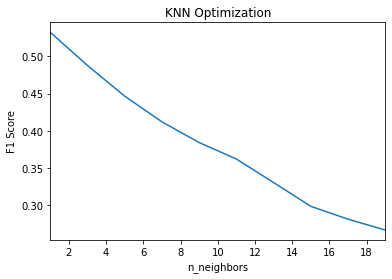

In [106]:
"""
  Find best parameter for number of neighbors
"""
n_range = list(range(1, 20, 2))
value_range = []
if should_run_tests:
  for val in n_range:
    score = get_assemble_score(
        expected_good_features, 
        testing_types,
        give_certain_models(
            OneVsRestClassifier, 
            KNeighborsClassifier,
            classifier_model_kwargs={"n_neighbors" : val}
        )
    )
    value_range.append(score)
  graph_values(value_range, n_range, "line", "n_neighbors", 
               "F1 Score", "KNN Optimization")

  print("Best number of neighbors is {}".format(
      pd.Series(value_range, index=n_range).idxmax())
  )

#### Conclusion

As the number of neighbors increases, the score gets continuously worse. I think this is because movies are not very alike, so a low number of them are going to be similar. In the training set we have, the best predictions are made from the 2 most similar, since n = 1.

### Optimizer SGDClassifier
We optimize the `alpha` value for an SGDClassifier

Best value for alpha is 9


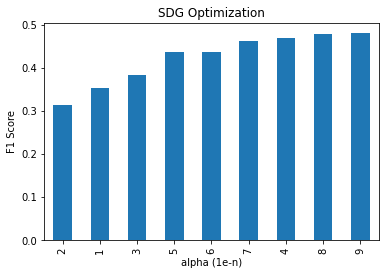

In [63]:
"""
  Finds best alpha for SDGClassifier
"""

alpha_range = list(range(1, 10))
value_range = []
if should_run_tests:
  for val in alpha_range:
    score = get_assemble_score(
        expected_good_features, 
        testing_types,
        give_certain_models(
            OneVsRestClassifier, 
            SGDClassifier,
            classifier_model_kwargs={
                "alpha" : (10 ** (-val)),
            }
        )
    )
    value_range.append(score)

  graph_values(value_range, alpha_range, "bar", 
               "alpha (1e-n)", "F1 Score", "SDG Optimization")
  print("Best value for alpha is {}".format(
      pd.Series(value_range, index=alpha_range).idxmax()))

#### Conclusion
A low alpha tends to be much better than a high alpha. However, it is best at 1e-8. It seems that after 1e-3, the classifier gets much worse.

### Optimize Features Selection
In the section, we curate overview (and create new feature called mod_overview) and test it along with all other features to determine what features best predict genres of a movie. 

In [0]:
"""
  This is used to remove unimportant words from the overview.
"""

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')  
stopwords = set(nltk.corpus.stopwords.words('english'))

if "mod_overview" not in df_movies.columns:
  def create_new_column_without_stopwords(df, column_before, column_after=None):
    words_series = (
      df[column_before].
      str.lower().
      str.replace("[^\w\s]", "").
      str.split()
    )

    # Function that makes string of non-stop words from original string
    def get_new_words(words):
      return " ".join([w for w in words if w not in stopwords])

    # Optional to either override column or provide new column name
    if column_after == None:
      df[column_before] = words_series.apply(get_new_words)
    else:
      df[column_after] = words_series.apply(get_new_words)

  # Make new DF with only overview and with id so we can merge later
  _temp_df = pd.DataFrame(df_movies[["id", "overview"]].copy().dropna())
  create_new_column_without_stopwords(_temp_df, "overview", "mod_overview")
  # Merge new column back into original dataframe
  df_movies = df_movies.merge(
      _temp_df.drop("overview", axis=1), how='left', on="id"
  )

  # Set new column's transformer type
  testing_types["mod_overview"] = "tfidf"

#### Test Features Individually to Find Best Features to Use

Goes through each feature and builds the model from **ONLY** that feature. Then it gets the F1 score with that feature alone. The graph produced tells us how well the features perform against each other.

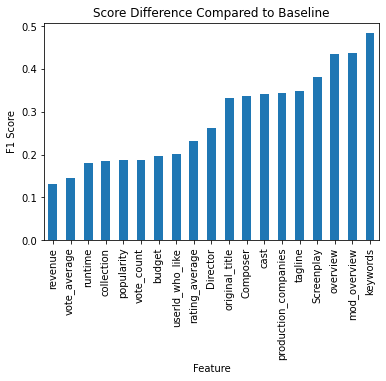

In [0]:
interesting_features_to_test = testing_types.keys()
for_sure_features = []
to_ignore = []

scores_series = pd.Series()
baseline_score = 0

for interest in interesting_features_to_test:
  # For testing... just skips features already being tested or ones
  # we do not want to test
  if interest in for_sure_features or interest in to_ignore:
    continue
  # Can add optional '""' column to get a baseline score
  if len(interest) > 0:
    columns_testing = for_sure_features + [interest]
  else:
    columns_testing = for_sure_features

  # Get score for that feature
  score = get_assemble_score(
      columns_testing, 
      testing_types,
      give_certain_models(
        OneVsRestClassifier, SGDClassifier
      )
  )

  # Add feature to series
  if len(interest) > 0:
    scores_series = scores_series.append(pd.Series(score, index=[interest]))
  else:
    baseline_score = score

# Graph series
diffs = (scores_series - baseline_score)
graph_values(list(diffs), diffs.index, "bar", "Feature", 
             "F1 Score", "Score Difference Compared to Baseline")

#### Conclusion

- Removing the unimportant words from overview (the plot summary) does not help our model.
- Textual features are much more helpful, as most of the top features (keywords, overview, tagline, and cast) are textual and are vectorizied. This makes sense, since genre would be best determined by things that describe what's going on in the movie.
- Other textual features that are One Hot Encoded also are better, like production_companies and Screenplay. Often, the same companies and writers make similar kinds of movies.
- Surprisingly, users who liked similar types of movies is not a good predictor for genre. Perhaps there is not enough data per user or that users in general just like a lot of different genres.
- Most quantitative variables are poor predictors. This is simply because they do not hold enough information about the movie. Adventure movies can have varying runtimes. The amount a movie makes in revenue is more based on its quality than genre.

From this, we've decided to use as our based predictors: **keywords, overview, Screenplay, cast, tagline, production_companies, Composer.**

In [0]:
features_to_test = [
    "keywords", "overview", "Screenplay", 
    "cast", "tagline", "production_companies",
    "Composer"
]

### Optimize Model Selection

Takes different models and tests them with the same features. This shows us which models work the best based on features we've decided to best predictors of genres in the previous section.

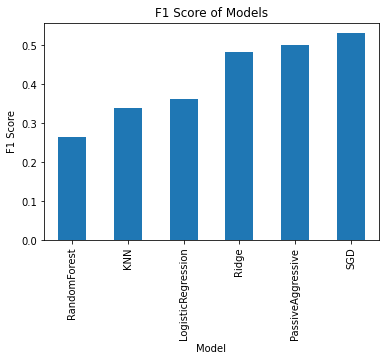

In [56]:
models = [
          (LogisticRegression, {"max_iter" : 1000}, "LogisticRegression"), 
          (KNeighborsClassifier, {"n_neighbors" : 2 }, "KNN"), 
          (SGDClassifier, { "alpha" : 1e-08 }, "SGD"), 
          (RandomForestClassifier, 
           { "max_depth" : 30, "random_state" : 0 }, 
           "RandomForest"
          ),
          (PassiveAggressiveClassifier, { "C" : 1 }, "PassiveAggressive"),
          (RidgeClassifier, { "alpha" : 1 }, "Ridge"),
          
]

scores_series = pd.Series()
baseline_score = 0

if should_run_tests:
  for model in models:
    # Get model's score
    score = get_assemble_score(
        features_to_test, 
        testing_types,
        give_certain_models(
          OneVsRestClassifier, 
          model[0],
          classifier_model_kwargs=model[1]
      )
    )

    # Add score, with index set to name of model
    scores_series = scores_series.append(pd.Series(score, index=[model[2]]))
  # Graph values
  graph_values(list(scores_series), scores_series.index, "bar", 
              "Model", "F1 Score", "F1 Score of Models")

#### Conclusions

It is clear from the graph that some models are better than others. Mainly, SGD, PassiveAggressive, and Ridge are by far the best.
Justification: SGD is known to be good in text classification, so the results makes sense given that most of our features are textual. 

## Predicting with our highly optimized model

In [0]:
import matplotlib.pyplot as plt 

optimized_model = get_assemble_estimator(
    features_to_test, testing_types, 
    give_certain_models(
          OneVsRestClassifier, 
          SGDClassifier,
          classifier_model_kwargs = { "alpha" : 1e-08}
      )
)

def plot_predictions_vs_actual(df, n=10, suffix="training"):
  X_test = df[features_to_test]
  for movie_id in range(0, n):
    y_test = optimized_model.predict(X_test[movie_id: movie_id + 1].fillna(""))
    # Predicted genres
    predicted_genres = []
    for i in range(len(y_test[0])):
      if y_test[0][i] == 1:
        predicted_genres.append(genres[i])

    # Actual genres
    actual_genres = []
    for genre, present in df.iloc[movie_id][:20].iteritems():
      if present == 1:
        actual_genres.append(genre)
    
    # plot
    movie_name = df["original_title"][movie_id]
    plt.bar(predicted_genres, 1, color='b', label='Predicted genres')
    plt.bar(actual_genres, 1, color='r', alpha=0.5, label='Actual Genres')
    plt.suptitle(movie_name)
    plt.legend()
    print("Saving...")
    plt.savefig("{}images/{}_{}.png".format(
        data_dir, movie_name.replace(" ", "_"), suffix)
    )
    plt.show()
    print("\n\n")


### Plot predictions of our model for genres vs. actual value on training data

/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


Saving...


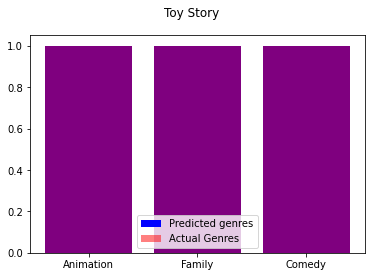




Saving...


/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


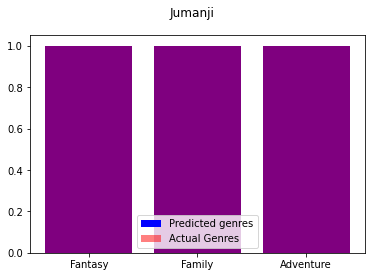




Saving...


/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


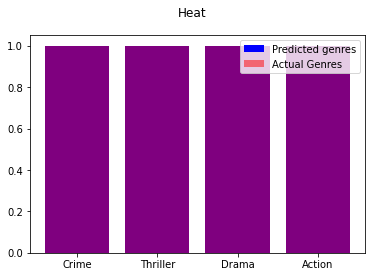




Saving...


/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


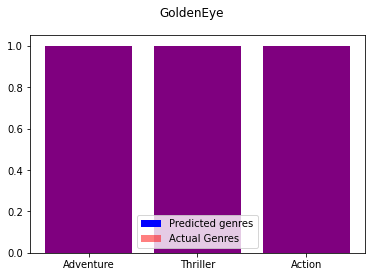




Saving...


/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


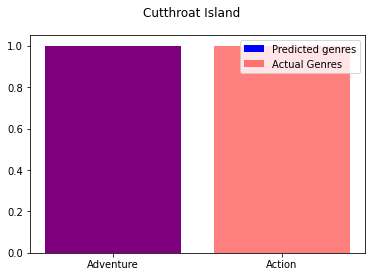




Saving...


/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


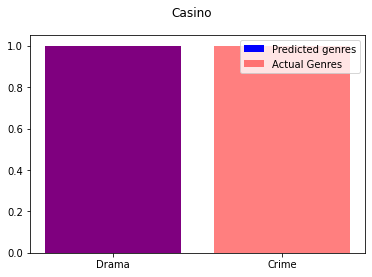




Saving...


/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


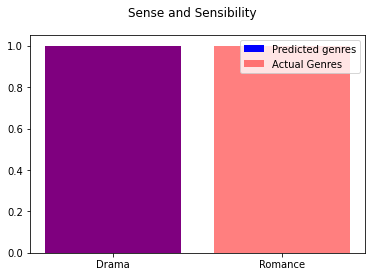




Saving...


/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


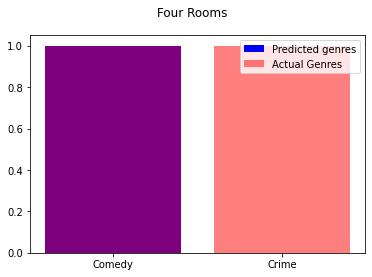




Saving...


/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


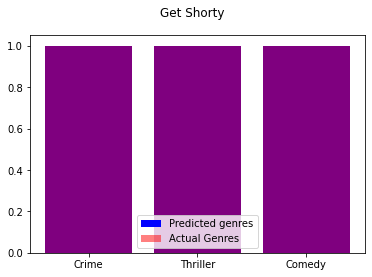




Saving...


/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


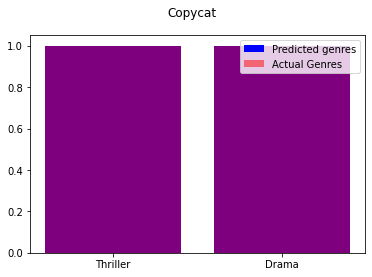

In [102]:
plot_predictions_vs_actual(df_movies, 10)

### Plot predictions of our model for genres vs. actual value on test data
This data was sampled and dropped from the training data earlier. 

/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


Saving...


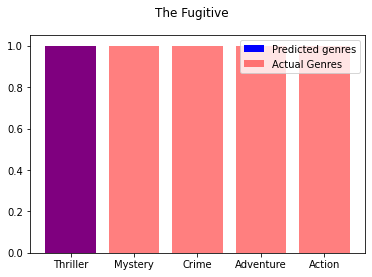




Saving...


/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


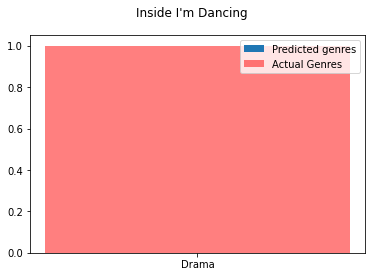




Saving...


/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


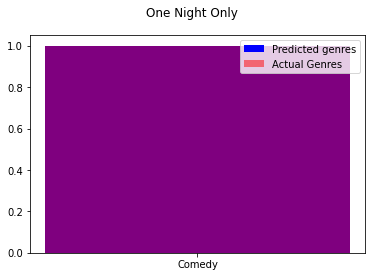

/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


Saving...


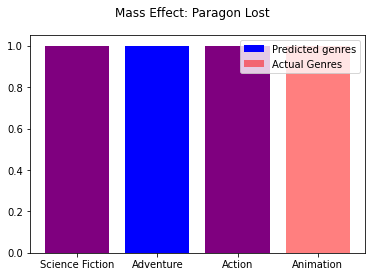




Saving...


/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


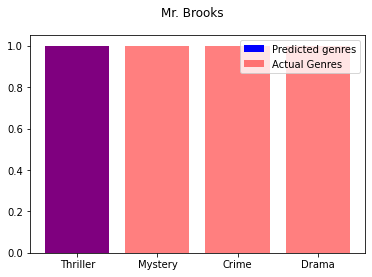




Saving...


/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


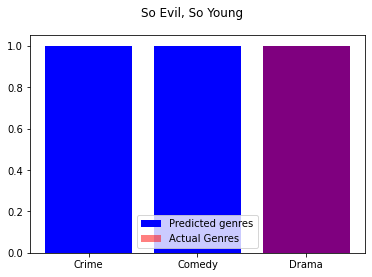




Saving...


/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


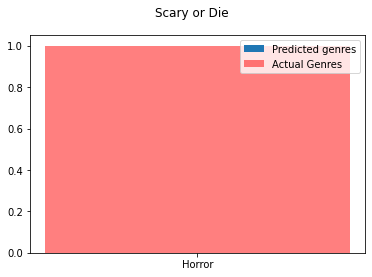

/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


Saving...


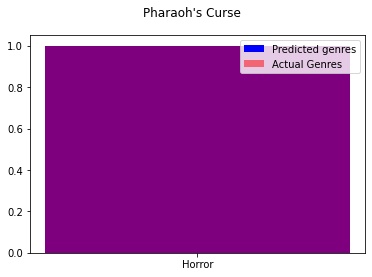




Saving...


/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


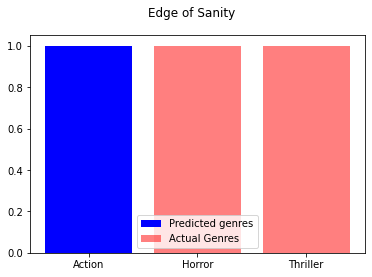




Saving...


/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


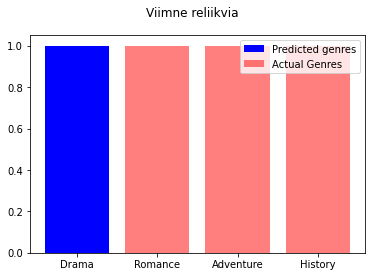

In [103]:
plot_predictions_vs_actual(df_movies_test, 10, suffix="test")

### Conclusion
It is evident that the predictions on training data was better than on test data. This makes sense because our model was trained on the training data. The best `f_score` that we had, which was aound ~0.5, also aligns with how often our predictions on test data is correct. 